<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Let's-set-up-some-common-file-paths" data-toc-modified-id="Let's-set-up-some-common-file-paths-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Let's set up some common file paths</a></span></li><li><span><a href="#Extract-sync-time-stamps" data-toc-modified-id="Extract-sync-time-stamps-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extract sync time stamps</a></span></li><li><span><a href="#Turn-spike-times-into-trains-and-firing-rates" data-toc-modified-id="Turn-spike-times-into-trains-and-firing-rates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Turn spike times into trains and firing rates</a></span></li><li><span><a href="#Chop-1-kHz-spike-data-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior" data-toc-modified-id="Chop-1-kHz-spike-data-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Chop 1 kHz spike data into trials and downsample, aligned to event timestamps extracted from behavior</a></span></li><li><span><a href="#Bandpass-and-smooth-LFP-in-standard-frequency-windows" data-toc-modified-id="Bandpass-and-smooth-LFP-in-standard-frequency-windows-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bandpass and smooth LFP in standard frequency windows</a></span></li><li><span><a href="#Chop-bandpassed-LFP-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior" data-toc-modified-id="Chop-bandpassed-LFP-into-trials-and-downsample,-aligned-to-event-timestamps-extracted-from-behavior-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Chop bandpassed LFP into trials and downsample, aligned to event timestamps extracted from behavior</a></span></li></ul></div>

Skeleton for final project...

## Let's set up some common file paths

In [1]:
import mat73
from os.path import join as pjoin
import glob

from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt


In [2]:
data_dir = "data_clean"
session = "George00_rec14_01282021"

bhv_fnames = sorted(glob.glob(pjoin(data_dir, session + "*bhv*"))) # could be >1
spk_fname = glob.glob(pjoin(data_dir, session + "*units*")) # expect 1
lfp_fname = glob.glob(pjoin(data_dir, session + "*LFP*")) # expect 1

## Extract sync time stamps

For each session, we want to pull out snippets around task events. Two standard sync points are the start (pictures are displayed on the screen) and end (animal makes a selection with a lever movement) of each trial. This function could be customized easily-- we just need a vector of time stamps (in seconds) to align the neural data.

In [3]:
def load_raw_bhv(bhv_fnames):
    """
    Load raw bhv (.bhv2 saved as .mat) into dict; consolidate 
    if split across multiple files (assume alpha order)
    
    Parameters:
    ----------
    bhv_fnames : list 
        File path(s) for behavior data
        
    Returns:
    -------
    bhv_data : dict
        All task data
        
    """
    
    bhv_data = defaultdict(list)
    
    for f in bhv_fnames:
        print(f)
        data = mat73.loadmat(f)

        data_vars = data["bhvdata"].keys()
        for v in data_vars:
            bhv_data[v] += data["bhvdata"][v]
            
    return bhv_data

def load_pl2_codes(spk_fname):
    """
    Load task event codes and corresponding time stamps from 
    raw spk (.pl2 saved as .mat).
    
    Parameters:
    ----------
    spk_fname : list
        File path for spk data; expected length 1
    
    Returns:
    -------
    pl2_codes : dict
        Event codes and timestamps from whole session
    
    """
    
    pl2_codes = mat73.loadmat(spk_fname[0], \
                              only_include=['event_codes', 'event_ts'])
    
    return pl2_codes

In [4]:
def get_trial_events(bhv_data, pl2_codes, event):
    """
    For each trial in bhv_data, pull time for this event code 
    (-1 if doesn't exist)
    
    Parameters:
    ----------
    bhv_data : dict
        All task data
    pl2_codes : dict
        Event codes and timestamps from whole session
    event : int
        Event code word
    
    Returns:
    -------
    timestamps : np vector
        Timestamps corresponding to event within each trial (or -1)
        
    """
    
    # cut up trials by default start and stop codes
    start_code = 9
    stop_code = 18
    
    trial_start = np.where(pl2_codes["event_codes"] == start_code)[0]
    trial_stop = np.where(pl2_codes["event_codes"] == stop_code)[0]
    
    # check that we have the same number of trials from bhv and pl2 data
    ntr = len(bhv_data["Trial"])
    if trial_start.shape[0] != ntr or trial_stop.shape[0] != ntr:
        raise ValueError("oops! mismatched bhv2 and pl2 trial counts")
    
    # cycle through all trials, save event time (if exists)
    timestamps = -1 * np.ones(ntr)
    for tr in range(ntr):
        
        # restrict to event codes in this trial
        codes = pl2_codes["event_codes"][trial_start[tr] : trial_stop[tr]]
        ts = pl2_codes["event_ts"][trial_start[tr] : trial_stop[tr]]
        
        idx = np.where(codes == event)[0]
        if idx.shape[0] == 1:
            timestamps[tr] = ts[idx]
    
    return timestamps
    

In [5]:
# load bhv data for this session
bhv_data = load_raw_bhv(bhv_fnames)

data_clean/George00_rec14_01282021-bhv_A.mat
data_clean/George00_rec14_01282021-bhv_B.mat
data_clean/George00_rec14_01282021-bhv_C.mat


In [6]:
# load spk events for this session
pl2_codes = load_pl2_codes(spk_fname)

(array([863.,  77.,  70.,  70.,  75.,  67.,  52.,  51.,  49.,  43.]),
 array([-1.00000000e+00,  7.05580460e+02,  1.41216092e+03,  2.11874138e+03,
         2.82532184e+03,  3.53190230e+03,  4.23848276e+03,  4.94506322e+03,
         5.65164368e+03,  6.35822414e+03,  7.06480460e+03]),
 <BarContainer object of 10 artists>)

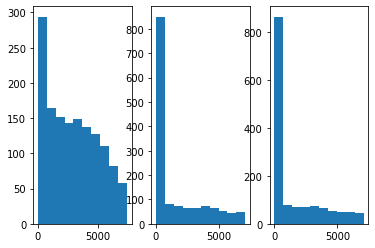

In [7]:
# get time stamps for pictures and lever responses
ts_pics = get_trial_events(bhv_data, pl2_codes, 20)
ts_left = get_trial_events(bhv_data, pl2_codes, 23)
ts_right = get_trial_events(bhv_data, pl2_codes, 24)

fig = plt.figure()

ax = fig.add_subplot(1, 3, 1)
ax.hist(ts_pics)

ax = fig.add_subplot(1, 3, 2)
ax.hist(ts_left)

ax = fig.add_subplot(1, 3, 3)
ax.hist(ts_right)

## Turn spike times into trains and firing rates

The raw data contains spike times at 40 kHz for each neuron. While this is an efficient way to store data, it's often more convenient to visualize/to analyses on spike trains (e.g. 0 0 1 1 0 0 1 0) or smoothed firing rates (trains with 50ms boxcar smoothing) at 1 kHz.

## Chop 1 kHz spike data into trials and downsample, aligned to event timestamps extracted from behavior

Using the time stamps pulled from the behavior, we can look at the same time period across all trials synced to specific events (e.g. start or end of trial).

## Bandpass and smooth LFP in standard frequency windows


## Chop bandpassed LFP into trials and downsample, aligned to event timestamps extracted from behavior